# DIFFUSION MODEL DATA Generation
> Created Dec. 2024 <br>
> Nikhil Bisht<br>

# Definitions

In [3]:
# standard system modules
import os, sys
import h5py 
import argparse
# standard module for tabular data
import pandas as pd
import json

# standard module for array manipulation
import numpy as np
from itertools import permutations

# standard statistical module
import scipy.stats as st
from scipy import linalg
from scipy.stats import ks_2samp


# standard module for high-quality plots
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# to plot pixelized images
import imageio.v3 as im

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from ddpm_conditional import *

from tqdm import tqdm

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset_AllData_AutoEnc.h5'
IMAGEINPUT = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/Images_Input_2D/'
IMAGEOUTPUT = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/Images_Output_2D/'
CORESET  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_all_frames.h5'
MODELFILE = 'nnmodel.dict'

IMAGESIZE = 128

TARGET = ['Vx_f', 'Vy_f', 'Vz_f','Density_f']
POS_FEAT = ['X_f', 'Y_f', 'Z_f','X_i', 'Y_i', 'Z_i']
FEATURES = ['Vx_i', 'Vy_i', 'Vz_i','Density_i']

FRAMES = [30, 90]


#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


# Functions

In [66]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


def get_data(args, input_arr, labels):
    dataset = TensorDataset(input_arr, labels)
    dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    return dataloader

    
def plot_3d_data(d, filename='xy_data.png', dont_show = False):

    x1, x2, x3 = d[:, 0], d[:, 1], d[:, 2]
    xmin, xmax = min(x1), max(x1)
    ymin, ymax = min(x2), max(x2)
    zmin, zmax = min(x3), max(x3)
    
    fig = plt.figure(figsize=(13, 4))
    fig.tight_layout()
    
    ax  = fig.add_subplot(1, 3, 1)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'$x$')
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(r'$y$')
    ax.scatter(x1, x2, s=0.5, color='steelblue', alpha=0.4)
    ax.grid('both')

    ax2  = fig.add_subplot(1, 3, 2)
    ax2.set_xlim(zmin, zmax)
    ax2.set_xlabel(r'$z$')
    ax2.set_ylim(ymin, ymax)
    ax2.set_ylabel(r'$y$')
    ax2.scatter(x3, x2, s=0.5, color='steelblue', alpha=0.4)
    ax2.grid('both')

    ax3  = fig.add_subplot(1, 3, 3)
    ax3.set_xlim(xmin, xmax)
    ax3.set_xlabel(r'$x$')
    ax3.set_ylim(zmin, zmax)
    ax3.set_ylabel(r'$z$')
    ax3.scatter(x1, x3, s=0.5, color='steelblue', alpha=0.4)
    ax3.grid('both')
    
    if filename:
        plt.savefig(filename)
    
    if dont_show==False:
        plt.show()
    plt.close()

def plot_img(Initial_fname, Final_fname, save_filename='xy_data.png', dont_show = False):

    i_file = open(Initial_fname, 'r')
    infile = json.load(i_file)
    o_file = open(Final_fname, 'r')
    outfile = json.load(o_file)

    x1_scalor, x2_scalor, = infile['scalor'], outfile['scalor']
    x1, x2, = np.array(infile['img'])*x1_scalor, np.array(outfile['img'])*x2_scalor
    x1_edges, x2_edges, = infile['edges'], outfile['edges']
    i_file.close()
    o_file.close()

    fig = plt.figure(figsize=(9, 4))
    fig.tight_layout()
    
    ax  = fig.add_subplot(1, 2, 1)
    c = ax.pcolormesh(x1_edges[0], x1_edges[1], x1.T)
    fig.colorbar(c, ax=ax)
    ax.grid('both')

    ax2  = fig.add_subplot(1, 2, 2)
    c = ax2.pcolormesh(x2_edges[0], x2_edges[1], x2.T)
    fig.colorbar(c, ax=ax2)
    ax2.grid('both')

    if save_filename:
        plt.savefig(save_filename)
    
    if dont_show==False:
        plt.show()
    plt.close()

def data_augmentation_periodic(images_dictionary):
    new_imgs_dictionary = {}
    new_num = 0
    for img_num in images_dictionary.keys():
        img_data = images_dictionary[img_num]
        initial_img = img_data['initial_img']
        label = img_data['label']
        final_img = img_data['final_img']
        #setup periodic wrap. shift to the right in steps of 128/4 = 32 pixels
        shift1_i, shift1_f = np.zeros(initial_img.shape), np.zeros(final_img.shape)
        shift2_i, shift2_f = np.zeros(initial_img.shape), np.zeros(final_img.shape)
        shift3_i, shift3_f = np.zeros(initial_img.shape), np.zeros(final_img.shape)
        
        shift1_i[:96,:], shift1_f[:96,:] = initial_img[32:,:], final_img[32:,:]
        shift1_i[96:,:], shift1_f[96:,:] = initial_img[0:32,:], final_img[0:32,:]

        shift2_i[:64,:], shift2_f[:64,:] = initial_img[64:,:], final_img[64:,:]
        shift2_i[64:,:], shift2_f[64:,:] = initial_img[0:64,:], final_img[0:64,:]

        shift3_i[:32,:], shift3_f[:32,:] = initial_img[96:,:], final_img[96:,:]
        shift3_i[32:,:], shift3_f[32:,:] = initial_img[0:96,:], final_img[0:96,:]

        new_imgs_dictionary['imgs1_'+str(new_num)] = {'initial_img':shift1_i, 'final_img': shift1_f, 'imgedges': img_data['imgedges'], 'imgscalor': img_data['imgscalor'], 'label': (label[0],label[1],1)}
        new_imgs_dictionary['imgs2_'+str(new_num)] = {'initial_img':shift2_i, 'final_img': shift2_f, 'imgedges': img_data['imgedges'], 'imgscalor': img_data['imgscalor'], 'label': (label[0],label[1],2)}
        new_imgs_dictionary['imgs3_'+str(new_num)] = {'initial_img':shift3_i, 'final_img': shift3_f, 'imgedges': img_data['imgedges'], 'imgscalor': img_data['imgscalor'], 'label': (label[0],label[1],3)}
        new_num+=1

    return new_imgs_dictionary

def store_imgs(img_dict, input_dir = IMAGEINPUT, output_dir = IMAGEOUTPUT, rewrite = 1):
    if rewrite==1:
        num = 0
    else:
        num = len(os.listdir(input_dir))
    for img_num in img_dict.keys():
        img_data = img_dict[img_num]
        input_fname = input_dir+"img_"+str(num).zfill(4)+".json"
        output_fname = output_dir+"img_"+str(num).zfill(4)+".json"
        num+=1
        if rewrite == 1:
            infile = open(input_fname, 'w')
            outfile = open(output_fname, 'w')
        if rewrite == 0 and os.path.isfile(input_fname):
            print("File exists!")
            return False
        initial_img = {'img': img_data['initial_img'].tolist(), 'edges': img_data['imgedges'], 'scalor': img_data['imgscalor'], 'label': img_data['label']}
        final_img = {'img': img_data['final_img'].tolist(), 'edges': img_data['imgedges'], 'scalor': img_data['imgscalor'], 'label': img_data['label']}
        json.dump(initial_img, infile)
        json.dump(final_img, outfile)
        if rewrite == 1:
            infile.close()
            outfile.close()

# Load Sample

117364
          X_30      Y_30      Z_30      X_90      Y_90      Z_90
1405  0.548724  0.157302  0.951530  0.595116  0.176636  0.909511
1488  0.082750  0.207655  0.949522  0.009861  0.281809  0.935002
1489  0.092412  0.216760  0.954083  0.014970  0.286047  0.930372
1490  0.101305  0.218718  0.957615  0.015045  0.285351  0.929440
1531  0.534520  0.165883  0.983209  0.594324  0.178367  0.914770
(117364, 3)


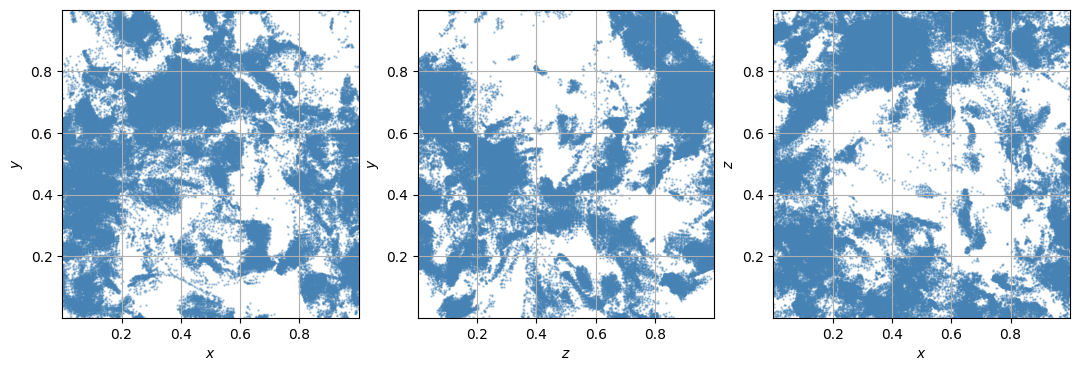

(117364, 3)


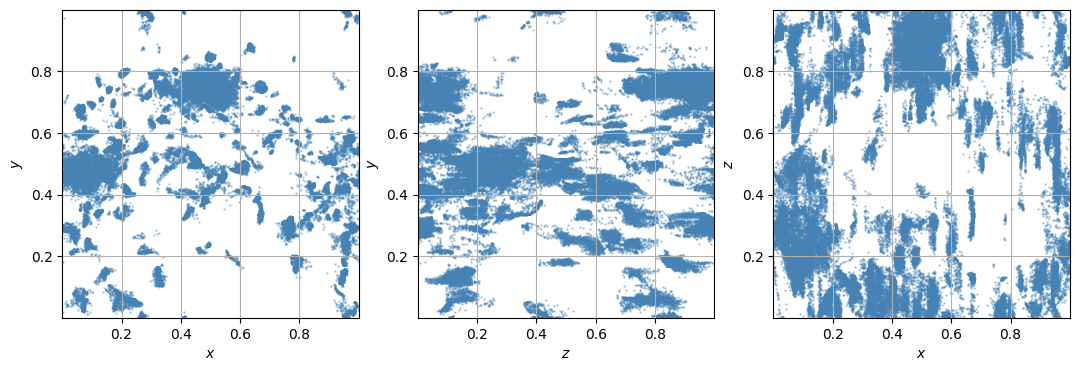

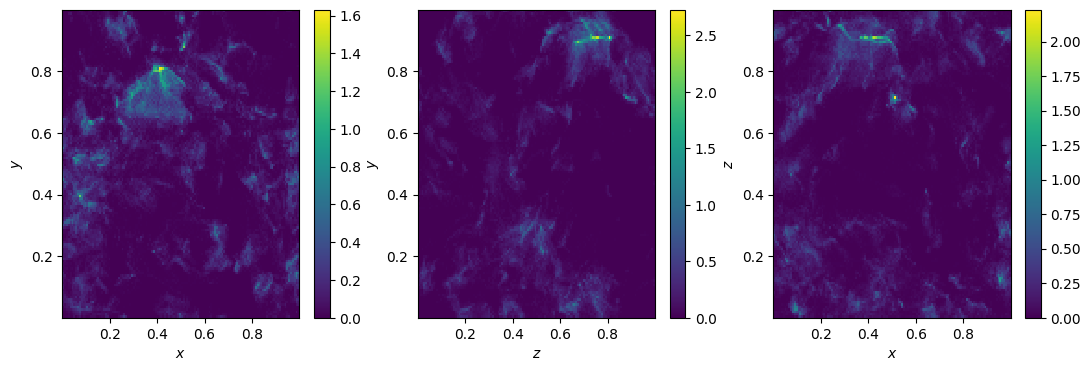

(128, 128, 128)


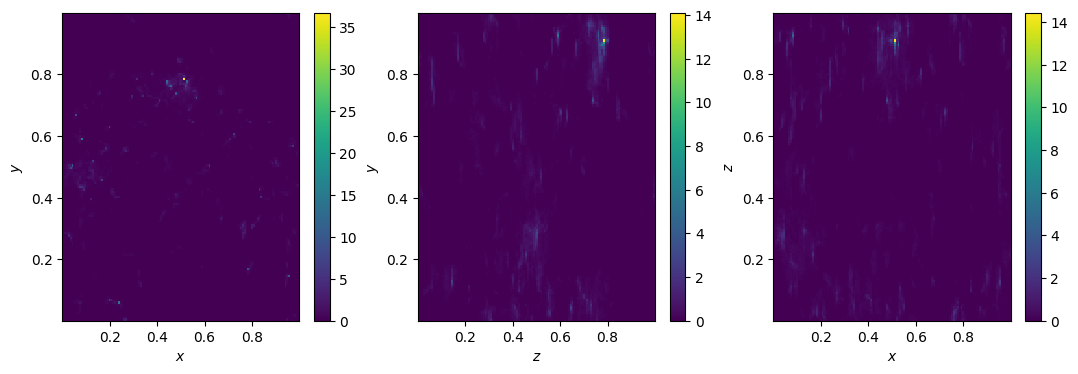

(128, 128, 128)


In [32]:
#get data and prepare sample
df_timeseries = pd.DataFrame([])
f =  h5py.File(DATAFILE, 'r')
for frame_num in FRAMES:
    for cname in ['X', 'Y', 'Z']:
        column_name = cname+"_"+str(frame_num)
        f_frame = f[str(frame_num)]
        if frame_num == 0:
            df_timeseries['Particle_id'] = f_frame['Particle_id'][()]
            df_timeseries['Particle_id'] = df_timeseries['Particle_id'].astype('int32')
            df_timeseries[column_name] = f_frame[cname][()]
            df_timeseries = df_timeseries.set_index('Particle_id')
        else:
            appended_series = pd.Series(f_frame[cname][()], index=np.array(f_frame['Particle_id'][()], dtype=int), name = column_name)
            df_timeseries.insert(len(df_timeseries.columns), column_name, appended_series)

f.close()

#get core stuff
df_core_pids =[]
with h5py.File(CORESET, 'r') as f:
    tm = f['track_manager']
    df_core_pids = tm['particle_ids'][()]

#Now we split noncore and core
df_timeseries_core = df_timeseries.loc[df_core_pids]
df_timeseries_noncore = df_timeseries.drop(df_core_pids)

print(len(df_timeseries_core))
print(df_timeseries_core.head())
initial_dataset_core = df_timeseries_core[['X_'+str(FRAMES[0]), 'Y_'+str(FRAMES[0]), 'Z_'+str(FRAMES[0])]].to_numpy()
final_dataset_core = df_timeseries_core[['X_'+str(FRAMES[1]), 'Y_'+str(FRAMES[1]), 'Z_'+str(FRAMES[0])]].to_numpy()
print(initial_dataset_core.shape)
plot_3d_data(initial_dataset_core, "initial_core_data.png")
print(final_dataset_core.shape)
plot_3d_data(final_dataset_core, "final_core_data.png")
H_initial, edges = np.histogramdd(initial_dataset_core, bins = (IMAGESIZE, IMAGESIZE, IMAGESIZE))
H_final, edges = np.histogramdd(final_dataset_core, bins = edges)
#Normalize both histograms to max value from initial hist
initial_scalor = max(H_initial.flatten())
H_final = (H_final/(initial_scalor))
H_initial = (H_initial/initial_scalor)
plot_3dhist(H_initial, edges, "initial_core_image.png")
print(H_initial.shape)
plot_3dhist(H_final, edges, "final_core_image.png")
print(H_final.shape)
images_dictionary = {}
for num in range(IMAGESIZE):
    images_dictionary['imgxy_'+str(num)] = {'initial_img':H_initial[:,:,num],'final_img': H_final[:,:,num], 'imgedges': [edges[0].tolist(),edges[1].tolist()], 'imgscalor': initial_scalor, 'label': ('xy',num,0)}
    images_dictionary['imgyz_'+str(num)] = {'initial_img':H_initial[num,:,:],'final_img': H_final[num,:,:], 'imgedges': [edges[1].tolist(),edges[2].tolist()], 'imgscalor': initial_scalor, 'label': ('yz',num,0)}
    images_dictionary['imgxz_'+str(num)] = {'initial_img':H_initial[:,num,:],'final_img': H_final[:,num,:], 'imgedges': [edges[0].tolist(),edges[2].tolist()], 'imgscalor': initial_scalor, 'label': ('xz',num,0)}
store_imgs(images_dictionary)

## Data Augmentation!

In [56]:
images_dictionary_peridoic = data_augmentation_periodic(images_dictionary)
store_imgs(images_dictionary_peridoic)


### Plot Images

In [68]:
input_imgs = os.listdir(IMAGEINPUT)
input_imgs.sort()
output_imgs = os.listdir(IMAGEOUTPUT)
output_imgs.sort()
some_plot_number_limit = 3 #len(input_imgs)
for img_num in range(100,150):
    plot_img(IMAGEINPUT+input_imgs[img_num], IMAGEOUTPUT+output_imgs[img_num], save_filename='./plot_images/'+str(input_imgs[img_num])[0:8]+'.png', dont_show = True)